In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge

from batcar import BatCar
from batcar.model_updater import ModelUpdater
from batcar.model_updater.data_selectors import (
    AllSelector, 
    RecentSelector
)
from batcar.update_trigger import (
    PeriodicTrigger, 
    MonthlyTrigger, 
    ScheduledTrigger
)
from batcar.model_updater.wrappers import FrameIO

In [3]:
plt.style.use('makina-notebook')

# Generate Synthetic Data

Text(0.5, 1.0, 'Synthetic Data')

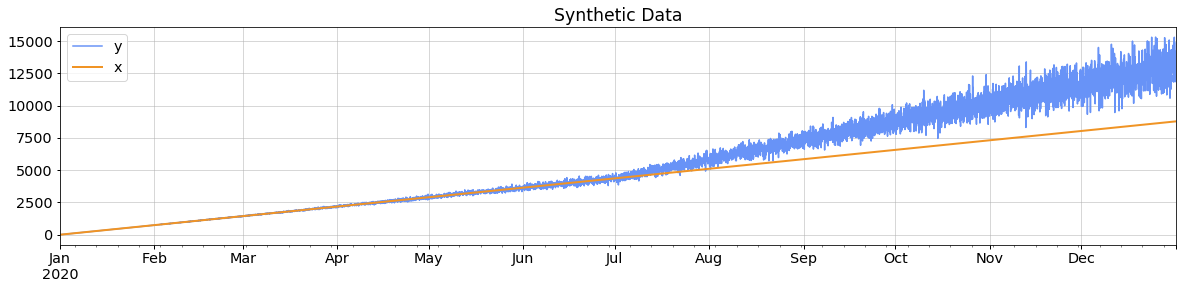

In [4]:
data_times = pd.date_range('2020-01-01 00:00:00', '2021-01-01 00:00:00', freq='1h', closed='left')

n_samples = len(data_times)
n_phase1 = int(n_samples / 2)
n_phase2 = n_samples - n_phase1

x = pd.DataFrame(np.arange(n_samples).reshape(-1, 1), index=data_times, columns=['x'])

y1_clean = np.arange(n_phase1)
y2_clean = np.arange(n_phase2) * 2 + y1_clean[-1]

y_clean = pd.DataFrame(np.concatenate([y1_clean, y2_clean]), index=data_times, columns=['y'])
y_noise = np.random.randn(*y_clean.shape) * (y_clean * 0.03) * (x.to_numpy()*0.0003)

y = y_clean + y_noise

ax = y.plot.line(figsize=(20,4))
ax = x.plot.line(lw=2, ax=ax)
ax.set_title('Synthetic Data')

# Define Model

- Any object implementing `fit` and `predict` can be used.
- If the object has `numpy.array`-based IO, use wrapper `FrameIO` to make it have `pandas.DataFrame-based` IO.


In [5]:
model = FrameIO(Ridge())

# Run BatCar

## Periodic Trigger

In [6]:
update_interval = '31 days'

data_selector = RecentSelector(744)
model_updater = ModelUpdater.from_generator(model, data_selector=data_selector)

batcar = BatCar(update_interval, model_updater)
batcar.drive(x, y, batch_size=1000)

100%|██████████| 9/9 [00:08<00:00,  1.05it/s]

|   episode | build_time          |
|----------:|:--------------------|
|         0 | 2020-02-01 00:00:00 |
|         1 | 2020-03-03 00:00:00 |
|         2 | 2020-04-03 00:00:00 |
|         3 | 2020-05-04 00:00:00 |
|         4 | 2020-06-04 00:00:00 |
|         5 | 2020-07-05 00:00:00 |
|         6 | 2020-08-05 00:00:00 |
|         7 | 2020-09-05 00:00:00 |
|         8 | 2020-10-06 00:00:00 |
|         9 | 2020-11-06 00:00:00 |
|        10 | 2020-12-07 00:00:00 |



## Monthly Trigger
- Often, we want to trigger model update per month.
- Because length of a month depends on that month, we cannot use PeriodicTrigger.
    - For instance, there are 31 days in January but 30 days in April.
- Instead, BatCar provides MonthlyTrigger for this case.

### Trigger at Specified Day and Time
- Every update has been done at the same day and time of every month.

In [7]:
update_day = 1
update_hour = 8
update_period = 1

update_trigger = MonthlyTrigger(update_day, update_hour, update_period)

data_selector = RecentSelector(744)
model_updater = ModelUpdater.from_generator(model, data_selector=data_selector)

batcar = BatCar(update_trigger, model_updater)
batcar.drive(x, y, batch_size=1000)

100%|██████████| 9/9 [00:08<00:00,  1.01it/s]

|   episode | build_time          |
|----------:|:--------------------|
|         0 | 2020-01-01 08:00:00 |
|         1 | 2020-02-01 08:00:00 |
|         2 | 2020-03-01 08:00:00 |
|         3 | 2020-04-01 08:00:00 |
|         4 | 2020-05-01 08:00:00 |
|         5 | 2020-06-01 08:00:00 |
|         6 | 2020-07-01 08:00:00 |
|         7 | 2020-08-01 08:00:00 |
|         8 | 2020-09-01 08:00:00 |
|         9 | 2020-10-01 08:00:00 |
|        10 | 2020-11-01 08:00:00 |
|        11 | 2020-12-01 08:00:00 |



### Trigger at The Same Day and Time that `BatCar.drive` Starts Running.
- In this case, for the first sample in `BatCar.drive`, model update is triggered.
- This makes run time error because there is no up

In [8]:
update_day = None
update_hour = None
update_period = 1

update_trigger = MonthlyTrigger(update_day, update_hour, update_period)

data_selector = RecentSelector(744)
model_updater = ModelUpdater.from_generator(model, data_selector=data_selector)

batcar = BatCar(update_trigger, model_updater)
batcar.drive(x, y, batch_size=1000)

100%|██████████| 9/9 [00:08<00:00,  1.03it/s]

|   episode | build_time          |
|----------:|:--------------------|
|         0 | 2020-01-01 00:00:00 |
|         1 | 2020-02-01 00:00:00 |
|         2 | 2020-03-01 00:00:00 |
|         3 | 2020-04-01 00:00:00 |
|         4 | 2020-05-01 00:00:00 |
|         5 | 2020-06-01 00:00:00 |
|         6 | 2020-07-01 00:00:00 |
|         7 | 2020-08-01 00:00:00 |
|         8 | 2020-09-01 00:00:00 |
|         9 | 2020-10-01 00:00:00 |
|        10 | 2020-11-01 00:00:00 |
|        11 | 2020-12-01 00:00:00 |



## Scheduled Trigger
- Sometimes, we want to update the model at particular times.
    - For instance, we may know the condition that updating the model is beneficial, but detecting it systematically is difficult.
    - Or, in some problem domain, it is typical to update the model by external signals.

In [9]:
holiday_times = [
    '2020-03-01 1:00:00',
    '2020-05-05 5:00:00',
    '2020-06-06 6:00:00',
    '2020-08-15 15:00:00',
    '2020-10-03 3:00:00',
    '2020-10-09 9:00:00',
    '2020-12-25 12:00:00',
]

update_trigger = ScheduledTrigger(holiday_times)

data_selector = RecentSelector(744)
model_updater = ModelUpdater.from_generator(model, data_selector=data_selector)

batcar = BatCar(update_trigger, model_updater)
batcar.drive(x, y, batch_size=1000)

100%|██████████| 9/9 [00:08<00:00,  1.03it/s]

|   episode | build_time          |
|----------:|:--------------------|
|         0 | 2020-03-01 01:00:00 |
|         1 | 2020-05-05 05:00:00 |
|         2 | 2020-06-06 06:00:00 |
|         3 | 2020-08-15 15:00:00 |
|         4 | 2020-10-03 03:00:00 |
|         5 | 2020-10-09 09:00:00 |
|         6 | 2020-12-25 12:00:00 |

